In [10]:
import matplotlib.pyplot as plt
import random as r
import pprint as pp
import numpy as np

In [11]:
# Define all structure
# Define type of slice and its parameters
slices = {
    'eMBB' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.3,
        'usage_pattern': {
            'distribution': 'randint',
            'params': (4000000, 800000000)
        }
      },
      'URLLC' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.2,
        'usage_pattern': {
            'distribution': 'randint',
            'params': (4000000, 800000000)
        }
      },
      'MIoT' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.15,
        'usage_pattern': {
            'distribution': 'randint',
            'params': (4000000, 800000000)
          }
      },
      'mMTC' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.15,
        'usage_pattern': {
            'distribution': 'randint',
            'params': (4000000, 800000000)
          }
      },
      'voice' : {
        'bandwidth_max': 100000000,
        'client_weight': 0.2,
        'usage_pattern': {
            'distribution': 'randint',
            'params': (4000000, 800000000)
          }
     }
}
          

# Define base station parameters
basestation = {
    'capacity': 20000000000,
    'coverage': 250,
    'ratios': {
        'URLLC': 0.01,
        'eMBB': 0.59,
        'mMTC': 0.05,
        'voice': 0.05,
        'MIoT': 0.2
    },
    'x': 200,
    'y': 200
}

# Define mobility patterns and its parameters
mobility_patterns = {
  'car': {
    'distribution': 'normal',
    'params':(0,7),
    'client_weight': 0.10
  },
  'walk': {
    'distribution': 'randint',
    'params': (-1, 1),
    'client_weight': 0.40
  },
  'stationary': {
    'distribution': 'normal',
    'params': (0, 0.1),
    'client_weight': 0.20
  },
  'tram': {
    'distribution': 'randint',
    'params': (-4, 4),
    'client_weight': 0.10
  },
  'slackperson':{
    'distribution': 'randint',
    'params':(0, 1),
    'client_weight': 0.20 
  }
}

In [12]:
# Define obj Client
class Client:
    def __init__(self, name, x, y, mobility_pattern, slice_type):
        self.name = name
        self.x = x
        self.y = y
        self.mobility_pattern = mobility_pattern
        self.slice_type = slice_type

In [13]:
# Define obj Mobility 
class Mobility:
    def __init__(self, name, distribution, params):
        self.name = name
        self.distribution = distribution
        self.params = params

In [14]:
# Define obj BaseStation
class BaseStation:
    def __init__(self, x, y, coverage, capacity):
        self.x = x
        self.y = y
        self.coverage = coverage
        self.capacity = capacity

In [15]:
# Define obj Slice
class Slice:
    def __init__(self, name, bandwith_max):
        self.name = name
        self.bandwidth_max = bandwidth_max

In [16]:
def get_random_mobility_pattern(vals, mobility_patterns):
    i = 0
    j = r.random()

    while vals[i] < j:
        i += 1

    return mobility_patterns[i]


def get_random_slice_type(vals):
    i = 0
    j = r.random()

    while vals[i] < j:
        i += 1
    return i

collected, slice_weights = 0, []
for key, value in slices.items():
    collected += value['client_weight']
    slice_weights.append(collected)

collected, mb_weights = 0, []
for key, value in mobility_patterns.items():
    collected += value['client_weight']
    mb_weights.append(collected)
    
m_patterns = []
for name, mb in mobility_patterns.items():
    mobility_pattern = Mobility(name, mb['distribution'], mb['params'])
    m_patterns.append(mobility_pattern)    

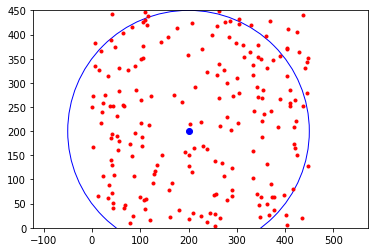

In [17]:
# Round 0: create network area, place base station and clients
num_clients = 200
simulation_time = 10
x_area = 450
y_area = 450

clients = []
for i in range(num_clients):
    x = r.randint(0, x_area)
    y = r.randint(0, y_area)
    
    mobility_pattern = get_random_mobility_pattern(mb_weights, m_patterns)
    slice_type = get_random_slice_type(slice_weights)
    
    c = Client(i, x, y, mobility_pattern, slice_type)
    
    clients.append(c)
 
base_station = BaseStation(basestation.get('x'), basestation.get('y'), basestation.get('coverage'), basestation.get('capacity'))

ax = plt.gca()
plt.axis('equal')
ax.set_xlim(0, x_area)
ax.set_ylim(0, y_area)
ax.plot(base_station.x, base_station.y, 'o', color='blue')
circle = plt.Circle((base_station.x,base_station.y), radius = base_station.coverage, fill=False, color='blue')
ax.add_artist(circle)
    
for i in range(num_clients):
    ax.plot(clients[i].x, clients[i].y,'.',color='red')

In [30]:
def isConnected(client, bs):
    if abs(client.x - bs.x < bs.coverage) and abs(client.y - bs.y < bs.coverage):
        print('True')
        return True
    else:
        return False
        print('False')
    
    
       
c = Client(10, 200, 500, get_random_mobility_pattern(mb_weights, m_patterns), get_random_slice_type(slice_weights))
station = BaseStation(basestation.get('x'), basestation.get('y'), basestation.get('coverage'), basestation.get('capacity'))

isConnected(c, station)

False